# Backtesting Flowchart
- Dollar base price is important 
- Add charts like x = 1, y = 7 We can analyze the indicators easier. 
- Step one getting the high quality processed data
- Step two Strategy selection part 
- Make the calculations give the profit rate & win-lose values
- Change the data interval to hourly, 30 min, 10 min & check the results again
- Create a loop for large scale backtesting
- Create a model for developing new indicators

In [1]:
import yfinance as yf, pandas as pd, matplotlib.pyplot as plt, pandas_ta as ta, numpy as np
import time
import os, math, time, warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap columns
pd.set_option('display.max_colwidth', None) # Show full content of each column
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def single_stock_analysis(symbol, period="2y"):
    """
    Analyze a single stock with all indicators over specified period
    
    Parameters:
    symbol: Stock symbol (e.g., "AAPL", "MGROS.IS")
    period: Time period ("1y", "2y", "5y", "max")
    """
    
    try:
        print(f"Downloading data for {symbol}...")
        ticker = yf.Ticker(symbol)
        
        # Get stock info
        stock_info = ticker.info
        basic_info = {
            "symbol": stock_info.get("symbol", symbol),
            "priceToBook": stock_info.get("priceToBook", None),
            "bookValue": stock_info.get("bookValue", None),
            "recommendationKey": stock_info.get("recommendationKey", None),
            "fiftyTwoWeekLow": stock_info.get("fiftyTwoWeekLow", None),
            "fiftyTwoWeekHigh": stock_info.get("fiftyTwoWeekHigh", None),
            "targetHighPrice": stock_info.get("targetHighPrice", None),
            "targetLowPrice": stock_info.get("targetLowPrice", None),
            "targetMeanPrice": stock_info.get("targetMeanPrice", None)
        }
        
        # Get historical data
        historical_data = ticker.history(period=period,interval="1h")
        
        if historical_data.empty:
            print(f"No historical data found for {symbol}")
            return None
        
        print(f"Processing {len(historical_data)} days of data...")
        
        # Calculate all indicators
        print("Calculating RSI...")
        historical_data['RSI'] = ta.rsi(historical_data['Close'], length=14)
        
        print("Calculating ADX...")
        adx_data = ta.adx(historical_data['High'], historical_data['Low'], historical_data['Close'], length=14)
        historical_data['ADX'] = adx_data['ADX_14']
        
        print("Calculating MACD...")
        macd = ta.macd(historical_data['Close'], fast=12, slow=26, signal=9)
        historical_data = pd.concat([historical_data, macd], axis=1)
        historical_data['MACDAS'] = historical_data['MACD_12_26_9'] - historical_data['MACDs_12_26_9']
        historical_data['MACDAS_Signal'] = historical_data['MACDAS'].ewm(span=9, adjust=False).mean()

        historical_data['CCI'] = ta.cci(historical_data['High'], historical_data['Low'], historical_data['Close'], length=20)
        historical_data['ROC'] = ta.roc(historical_data['Close'], length=12)
        historical_data['ATR'] = ta.atr(historical_data['High'], historical_data['Low'], historical_data['Close'], length=14)
        historical_data['MFI'] = ta.mfi(historical_data['High'], historical_data['Low'], historical_data['Close'], historical_data['Volume'], length=14)
        historical_data["FWMA"] = ta.fwma(historical_data['Close'], length=14)
        historical_data['OBV'] = ta.obv(historical_data['Close'], historical_data['Volume'])
        historical_data['CMF'] = ta.cmf(historical_data['High'], historical_data['Low'], historical_data['Close'], historical_data['Volume'])
        historical_data['AD'] = ta.ad(historical_data['High'], historical_data['Low'], historical_data['Close'], historical_data['Volume'])
        historical_data["VWAP"] = ta.vwap(historical_data['High'], historical_data['Low'], historical_data['Close'], historical_data['Volume'])
        historical_data["kama"] = ta.kama(historical_data['Close'], length=14)
        supertrend = ta.supertrend(historical_data['High'], historical_data['Low'], historical_data['Close'], length=10, multiplier=3)
        historical_data['Supertrend'] = supertrend['SUPERT_10_3.0']
        historical_data['Supertrend_direction'] = supertrend['SUPERTd_10_3.0']
        historical_data['EMA_200'] = ta.ema(historical_data['Close'], length=200)
        ichimoku = ta.ichimoku(historical_data['High'], historical_data['Low'], historical_data['Close'], 
                              tenkan=9, kijun=26, senkou=52, offset=26, include_chikou=True)
        
        if isinstance(ichimoku, tuple) and len(ichimoku) >= 2:
            ichi_df1, ichi_df2 = ichimoku[0], ichimoku[1]
            historical_data['Tenkan'] = ichi_df1['ITS_9'] if 'ITS_9' in ichi_df1.columns else None
            historical_data['Kijun'] = ichi_df1['IKS_26'] if 'IKS_26' in ichi_df1.columns else None
            historical_data['Senkou_A'] = ichi_df1['ISA_9'] if 'ISA_9' in ichi_df1.columns else None
            historical_data['Senkou_B'] = ichi_df1['ISB_26'] if 'ISB_26' in ichi_df1.columns else None
            historical_data['Chikou'] = ichi_df2['ICS_26'] if 'ICS_26' in ichi_df2.columns else None
        else:
            historical_data['Tenkan'] = None
            historical_data['Kijun'] = None
            historical_data['Senkou_A'] = None
            historical_data['Senkou_B'] = None
            historical_data['Chikou'] = None
        stoch = ta.stoch(historical_data['High'], historical_data['Low'], historical_data['Close'], k=14, d=3)
        historical_data['Stoch_K'] = stoch['STOCHk_14_3_3']
        historical_data['Stoch_D'] = stoch['STOCHd_14_3_3']
        stochrsi = ta.stochrsi(historical_data['Close'], length=14, rsi_length=14, k=3, d=3)
        historical_data['StochRSI_K'] = stochrsi['STOCHRSIk_14_14_3_3']
        historical_data['StochRSI_D'] = stochrsi['STOCHRSId_14_14_3_3']
        bollinger = ta.bbands(historical_data['Close'], length=20, std=2)
        historical_data['BB_Lower'] = bollinger.iloc[:, 0]
        historical_data['BB_Middle'] = bollinger.iloc[:, 1]
        historical_data['BB_Upper'] = bollinger.iloc[:, 2]
        historical_data['BB_BWidth'] = bollinger.iloc[:, 3]
        historical_data['BB_%B'] = bollinger.iloc[:, 4]
        print("Calculating derived metrics...")
        historical_data["YF%"] = ((historical_data["Close"] - historical_data["Close"].min()) / 
                                 (historical_data["Close"].max() - historical_data["Close"].min())) * 100
        historical_data["MACDAS_dif"] = historical_data["MACDAS"] - historical_data["MACDAS_Signal"]
        historical_data["change"] = historical_data["Close"].pct_change() * 100
        historical_data["BB_Pot"] = ((historical_data['BB_Upper'] / historical_data["Close"]) - 1) * 100
        historical_data["BB_Opt"] = ((historical_data['BB_Lower'] / historical_data["Close"]) - 1) * 100
        
        # Trend analysis
        historical_data["TrendWay"] = np.select([
            (historical_data["ADX"] > 20) & (historical_data["ROC"] > 0),
            (historical_data["ADX"] > 20) & (historical_data["ROC"] <= 0),
            historical_data["ADX"] <= 20
        ], ["upper", "lower", "no-trend"], default="unknown")
        
        # Ichimoku Cloud Analysis
        historical_data["Cloud_Position"] = np.select([
            (historical_data["Close"] > historical_data["Senkou_A"]) & 
            (historical_data["Close"] > historical_data["Senkou_B"]) & 
            historical_data["Senkou_A"].notna() & historical_data["Senkou_B"].notna(),
            (historical_data["Close"] < historical_data["Senkou_A"]) & 
            (historical_data["Close"] < historical_data["Senkou_B"]) & 
            historical_data["Senkou_A"].notna() & historical_data["Senkou_B"].notna()
        ], ["Above_Cloud", "Below_Cloud"], default="No_Data")
        
        historical_data["TK_Cross"] = np.select([
            (historical_data["Tenkan"] > historical_data["Kijun"]) & 
            historical_data["Tenkan"].notna() & historical_data["Kijun"].notna(),
            (historical_data["Tenkan"] < historical_data["Kijun"]) & 
            historical_data["Tenkan"].notna() & historical_data["Kijun"].notna()
        ], ["Bullish", "Bearish"], default="No_Data")
        
        # Add basic stock info as columns (for the latest data)
        for key, value in basic_info.items():
            historical_data[key] = value
        
        # Add timestamp
        historical_data['analysis_time'] = datetime.now()
        
        print(f"Analysis complete! Data shape: {historical_data.shape}")
        
        # Create CSVs directory if it doesn't exist and save to CSV
        csv_dir = "Backtesting_CSVs"
        if not os.path.exists(csv_dir):
            os.makedirs(csv_dir)
            print(f"Created directory: {csv_dir}")
        
        now = datetime.now().strftime("%d_%m_%y")
        filename = f"{csv_dir}/{symbol}_{period}_{now}.csv"
        historical_data.to_csv(filename)
        print(f"Data saved to: {filename}")
        
        # Display summary of latest values
        latest_data = historical_data.iloc[-1]
        print(f"\n=== Latest Values for {symbol} ===")
        print(f"Close Price: {latest_data['Close']:.2f}")
        print(f"RSI: {latest_data['RSI']:.2f}")
        print(f"ADX: {latest_data['ADX']:.2f}")
        print(f"MACD: {latest_data['MACD_12_26_9']:.4f}")
        print(f"Cloud Position: {latest_data['Cloud_Position']}")
        print(f"TK Cross: {latest_data['TK_Cross']}")
        print(f"Trend Way: {latest_data['TrendWay']}")
        print(f"Supertrend Direction: {latest_data['Supertrend_direction']}")
        
        return historical_data
        
    except Exception as e:
        print(f"Error analyzing {symbol}: {e}")
        return None

def analyze_multiple_stocks(stock_list, period="max"):
    """
    Analyze multiple stocks one by one
    """
    results = {}
    for i, symbol in enumerate(stock_list, 1):
        print(f"\n{'='*60}")
        print(f"Analyzing {i}/{len(stock_list)}: {symbol}")
        print(f"{'='*60}")
        
        result = single_stock_analysis(symbol, period)
        if result is not None:
            results[symbol] = result
        
        # Small delay to avoid overwhelming the API
        time.sleep(1)
    
    return results


# Example usage:
if __name__ == "__main__":
    # Define your stock lists (from your original code)
    #portfolio = ["MGROS.IS","KCHOL.IS","THYAO.IS","KRDMD.IS","CCOLA.IS","BRSAN.IS","ZOREN.IS","TTRAK.IS","AEFES.IS","FROTO.IS","ALCAR.IS"]
    #bist100 = ['AEFES.IS','AGHOL.IS','AHGAZ.IS','AKBNK.IS','AKCNS.IS','AKFGY.IS','AKFYE.IS','AKSA.IS','AKSEN.IS','ALARK.IS','ALBRK.IS','ALFAS.IS','ARCLK.IS','ASELS.IS','ASTOR.IS','BERA.IS','BIENY.IS','BIMAS.IS','BRSAN.IS','BRYAT.IS','BUCIM.IS','CANTE.IS','CCOLA.IS','CIMSA.IS','CWENE.IS','DOAS.IS','DOHOL.IS','ECILC.IS','ECZYT.IS','EGEEN.IS','ENJSA.IS','ENKAI.IS','EREGL.IS','EUPWR.IS','EUREN.IS','FROTO.IS','GARAN.IS','GENIL.IS','GESAN.IS','GLYHO.IS','GUBRF.IS','HALKB.IS','HEKTS.IS','IMASM.IS','IPEKE.IS','ISCTR.IS','ISDMR.IS','ISMEN.IS','IZMDC.IS','KARSN.IS','KAYSE.IS','KCAER.IS','KCHOL.IS','KMPUR.IS','KONTR.IS','KONYA.IS','KORDS.IS','KOZAA.IS','KOZAL.IS','KRDMD.IS','KZBGY.IS','MAVI.IS','MGROS.IS','MIATK.IS','ODAS.IS','OTKAR.IS','OYAKC.IS','PENTA.IS','PETKM.IS','PGSUS.IS','QUAGR.IS','SAHOL.IS','SASA.IS','SISE.IS','SKBNK.IS','SMRTG.IS','SOKM.IS','TAVHL.IS','TCELL.IS','THYAO.IS','TKFEN.IS','TOASO.IS','TSKB.IS','TTKOM.IS','TTRAK.IS','TUKAS.IS','TUPRS.IS','ULKER.IS','VAKBN.IS','VESBE.IS','YEOTK.IS','YKBNK.IS','YYLGD.IS','ZOREN.IS']

    # Example 1: Analyze a single stock for 2 years
    #print("=== Single Stock Analysis ===")
    apple_data = single_stock_analysis("EGGUB.IS", period="5y")
    
    # Example 2: Analyze your portfolio
    print("\n=== Portfolio Analysis ===")
    #portfolio_results = analyze_multiple_stocks(bist100[:94], period="max")  # First 3 stocks for demo
    
    # Example 3: Get maximum available data
    #print("\n=== Maximum Historical Data ===")
    #max_data = single_stock_analysis("MGROS.IS", period="max")



C:\Users\Tolga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas_ta\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


$EGGUB.IS: possibly delisted; no price data found  (period=5y) (Yahoo error = "1h data not available for startTime=1598733717 and endTime=1756413717. The requested range must be within the last 730 days.")


No historical data found for EGGUB.IS

=== Portfolio Analysis ===


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("Backtesting_CSVs/CCOLA.IS_max_22_07_25.csv")
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI,ADX,...,symbol,priceToBook,bookValue,recommendationKey,fiftyTwoWeekLow,fiftyTwoWeekHigh,targetHighPrice,targetLowPrice,targetMeanPrice,analysis_time
0,2000-05-10 00:00:00+03:00,8.653490,8.749640,8.557340,8.653490,175733000,0.0,0.0,NaN,NaN,...,CCOLA.IS,2.4392,20.806,none,42.94,899.5,92.0,70.0,80.10769,2025-07-22 01:55:36.432636
1,2000-05-11 00:00:00+03:00,8.461191,8.557341,8.268892,8.461191,182178000,0.0,0.0,NaN,NaN,...,CCOLA.IS,2.4392,20.806,none,42.94,899.5,92.0,70.0,80.10769,2025-07-22 01:55:36.432636
2,2000-05-12 00:00:00+03:00,8.557339,8.653489,8.365039,8.557339,149999000,0.0,0.0,NaN,NaN,...,CCOLA.IS,2.4392,20.806,none,42.94,899.5,92.0,70.0,80.10769,2025-07-22 01:55:36.432636
3,2000-05-15 00:00:00+03:00,8.172741,8.268891,8.076591,8.172741,126322000,0.0,0.0,NaN,NaN,...,CCOLA.IS,2.4392,20.806,none,42.94,899.5,92.0,70.0,80.10769,2025-07-22 01:55:36.432636
4,2000-05-16 00:00:00+03:00,7.980441,8.076590,7.884290,7.980441,68596000,0.0,0.0,NaN,NaN,...,CCOLA.IS,2.4392,20.806,none,42.94,899.5,92.0,70.0,80.10769,2025-07-22 01:55:36.432636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6477,2025-07-14 00:00:00+03:00,50.900002,51.150002,48.959999,49.000000,8142033,0.0,0.0,45.963537,14.082187,...,CCOLA.IS,2.4392,20.806,none,42.94,899.5,92.0,70.0,80.10769,2025-07-22 01:55:36.432636
6478,2025-07-16 00:00:00+03:00,49.000000,50.049999,48.360001,48.779999,9149678,0.0,0.0,45.176099,13.500569,...,CCOLA.IS,2.4392,20.806,none,42.94,899.5,92.0,70.0,80.10769,2025-07-22 01:55:36.432636
6479,2025-07-17 00:00:00+03:00,49.020000,49.840000,48.860001,49.660000,7707456,0.0,0.0,48.943943,12.960494,...,CCOLA.IS,2.4392,20.806,none,42.94,899.5,92.0,70.0,80.10769,2025-07-22 01:55:36.432636
6480,2025-07-18 00:00:00+03:00,49.880001,50.549999,49.660000,49.919998,6945369,0.0,0.0,50.036509,12.050096,...,CCOLA.IS,2.4392,20.806,none,42.94,899.5,92.0,70.0,80.10769,2025-07-22 01:55:36.432636


In [17]:
df2 = df.copy()
df2 = df2.dropna(subset=['Senkou_B'])  # Drop rows where RSI is NaN
df2[["Close","Volume","RSI","ADX","CCI","ROC","ATR","MFI","FWMA","OBV","CMF","AD","VWAP","kama","Supertrend","Supertrend_direction",
     "EMA_200","BB_%B","BB_Pot","BB_Pot","YF%","TrendWay","Cloud_Position"]]

,Close,Volume,RSI,ADX,CCI,ROC,ATR,MFI,FWMA,OBV,...,kama,Supertrend,Supertrend_direction,EMA_200,BB_%B,BB_Pot,BB_Pot,YF%,TrendWay,Cloud_Position
103,4.999794,33283000,33.785690,27.186080,-81.707752,-11.864418,0.203865,34.454224,4.984387,4.229816e+08,...,5.281867,5.465674,-1,NaN,0.264641,29.441565,29.441565,0.421820,lower,Below_Cloud
104,4.999794,0,33.785690,27.641690,-64.631041,-10.344831,0.189297,26.635908,4.989945,4.229816e+08,...,5.197704,5.465674,-1,NaN,0.285725,27.244539,27.244539,0.421820,lower,Below_Cloud
105,4.999794,50805200,33.785690,28.589041,-68.734269,-10.344831,0.189511,26.447846,4.993455,4.229816e+08,...,5.141510,5.417782,-1,NaN,0.300049,23.561820,23.561820,0.421820,lower,Below_Cloud
106,4.999794,0,33.785690,29.468580,-52.416823,-10.344831,0.175970,26.601180,4.995601,4.229816e+08,...,5.103759,5.417782,-1,NaN,0.314966,20.290967,20.290967,0.421820,lower,Below_Cloud
107,4.999794,0,33.785690,30.285173,-48.109965,0.000000,0.163396,26.601180,4.997064,4.229816e+08,...,5.076064,5.416245,-1,NaN,0.333346,18.077956,18.077956,0.421820,lower,Below_Cloud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6477,49.000000,8142033,45.963537,14.082187,14.379604,2.040815,1.686563,66.573180,50.056461,1.471502e+11,...,50.339394,47.388729,1,105.248104,0.469486,8.799410,8.799410,5.435684,no-trend,Below_Cloud
6478,48.779999,9149678,45.176099,13.500569,-13.017211,1.837155,1.686809,59.148855,49.569239,1.471410e+11,...,50.324133,47.388729,1,104.686232,0.435484,9.291806,9.291806,5.410615,no-trend,Below_Cloud
6479,49.660000,7707456,48.943943,12.960494,-2.237033,0.934957,1.642037,63.550089,49.604381,1.471487e+11,...,50.310690,47.388729,1,104.138708,0.529878,7.350888,7.350888,5.510892,no-trend,Below_Cloud
6480,49.919998,6945369,50.036509,12.050096,18.021396,-0.755469,1.588320,67.198328,49.725932,1.471557e+11,...,50.300782,47.388729,1,103.599218,0.544122,6.664597,6.664597,5.540519,no-trend,Below_Cloud


C:\Users\Tolga\AppData\Local\Temp\ipykernel_23192\3419228577.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\Tolga\AppData\Local\Temp\ipykernel_23192\3419228577.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


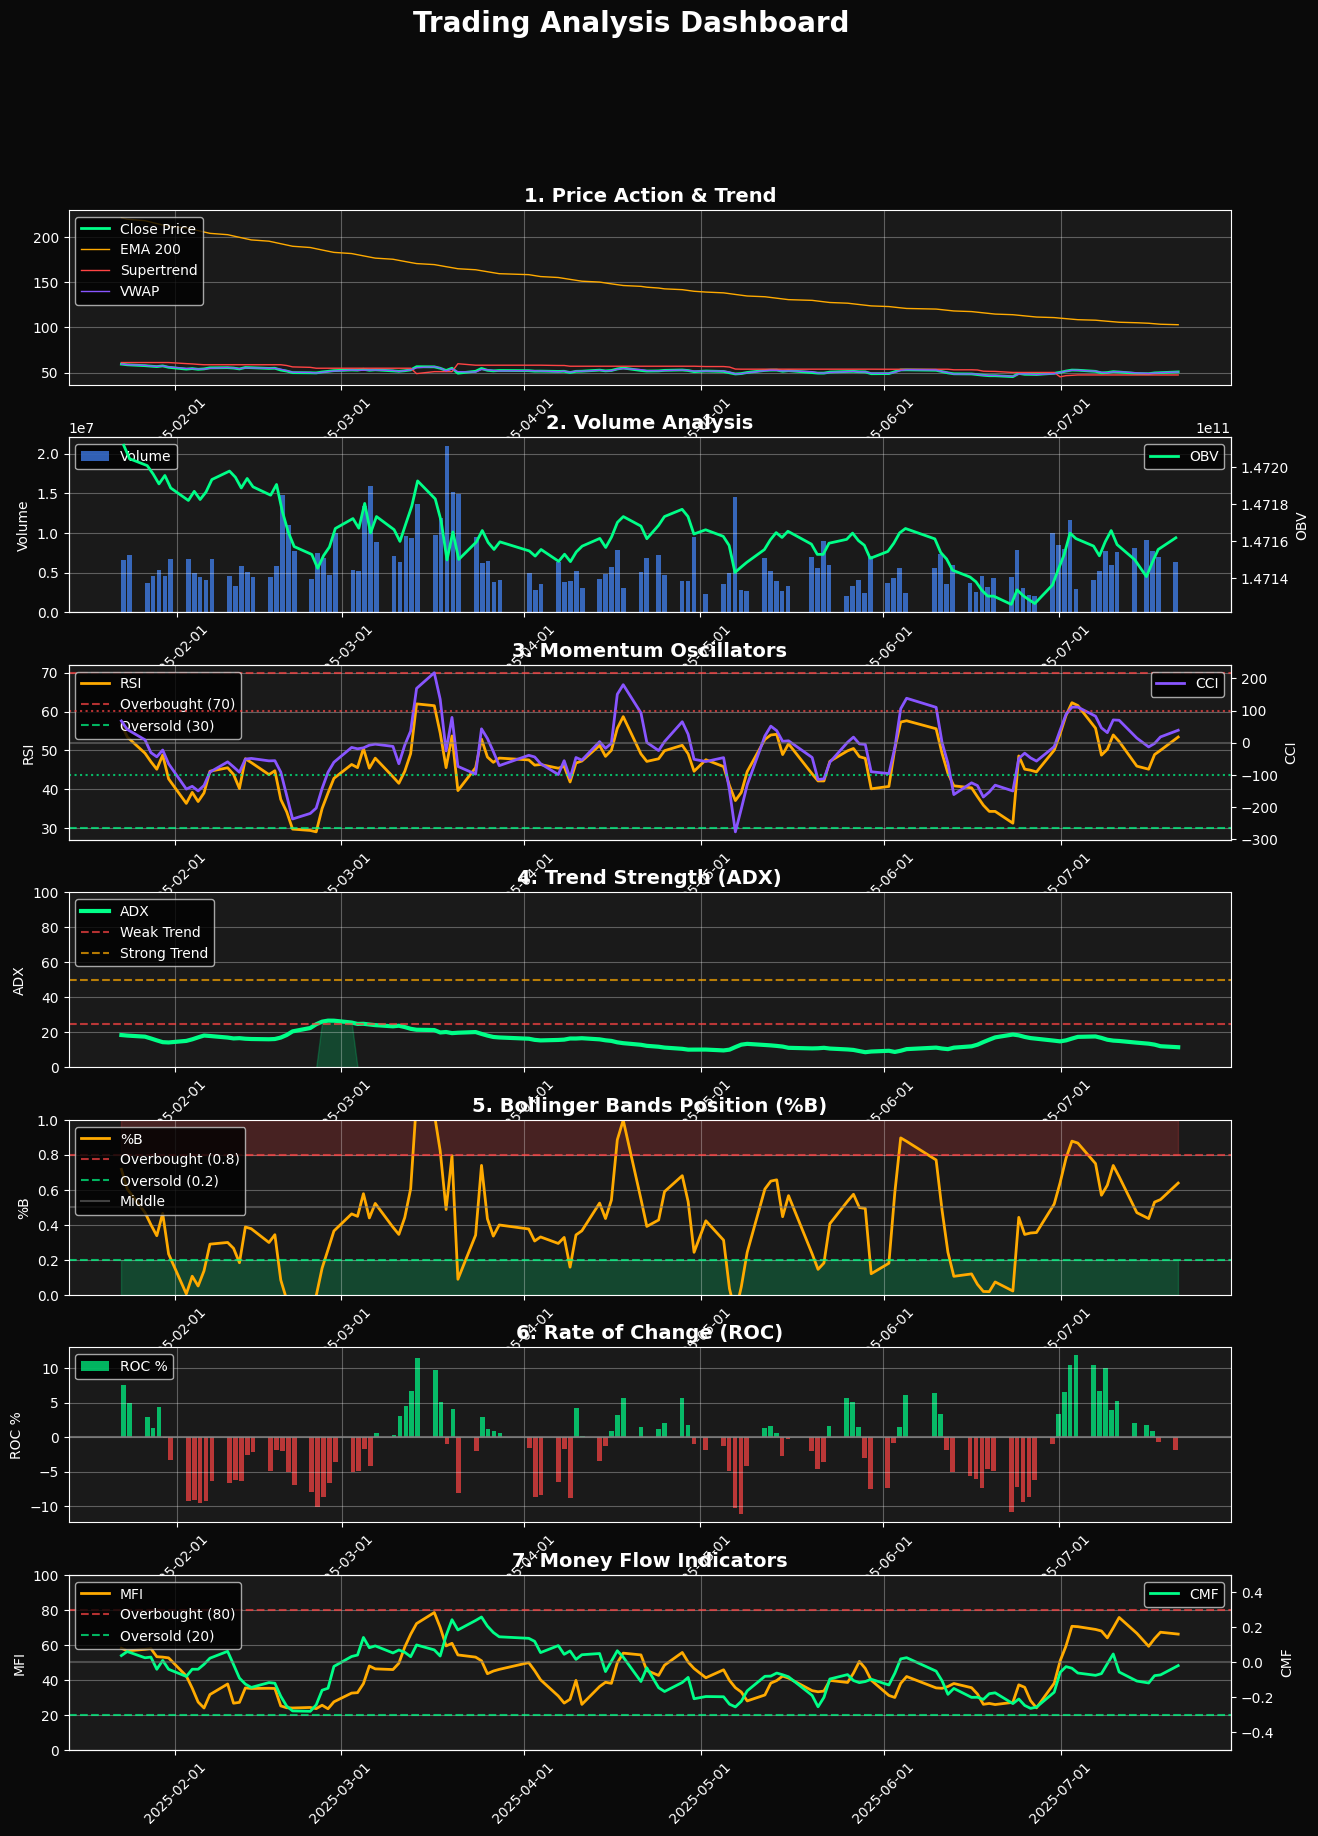

Dashboard created successfully!
To use with your data, uncomment and modify the example usage section.


In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

# Set style
plt.style.use('dark_background')
sns.set_palette("husl")

def create_trading_dashboard(df, figsize=(15, 20)):
    """
    Create a comprehensive trading dashboard with 7 charts
    
    Parameters:
    df: DataFrame with your trading data
    figsize: tuple for figure size
    """
    
    # Create figure with subplots
    fig = plt.figure(figsize=figsize, facecolor='#0a0a0a')
    gs = GridSpec(7, 1, figure=fig, hspace=0.3)
    
    # Ensure we have a datetime index for better x-axis formatting
    if not isinstance(df.index, pd.DatetimeIndex):
        # If you have a date column, use it. Otherwise create a date range
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date')
        else:
            # Create synthetic dates for demonstration
            dates = pd.date_range(start='2024-01-01', periods=len(df), freq='D')
            df = df.copy()
            df.index = dates
    
    # Chart 1: Price Action & Trend
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_facecolor('#1a1a1a')
    
    # Plot price lines
    ax1.plot(df.index, df['Close'], color='#00ff88', linewidth=2, label='Close Price')
    if 'EMA_200' in df.columns:
        ax1.plot(df.index, df['EMA_200'], color='#ffaa00', linewidth=1, label='EMA 200')
    if 'Supertrend' in df.columns:
        ax1.plot(df.index, df['Supertrend'], color='#ff4444', linewidth=1, label='Supertrend')
    if 'VWAP' in df.columns:
        ax1.plot(df.index, df['VWAP'], color='#8855ff', linewidth=1, label='VWAP')
    
    ax1.set_title('1. Price Action & Trend', fontsize=14, fontweight='bold', color='white')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(colors='white')
    
    # Chart 2: Volume Analysis
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_facecolor('#1a1a1a')
    
    # Volume bars
    ax2.bar(df.index, df['Volume'], color='#4488ff', alpha=0.7, label='Volume')
    ax2.set_ylabel('Volume', color='white')
    ax2.tick_params(colors='white')
    
    # OBV on secondary axis
    if 'OBV' in df.columns:
        ax2_twin = ax2.twinx()
        ax2_twin.plot(df.index, df['OBV'], color='#00ff88', linewidth=2, label='OBV')
        ax2_twin.set_ylabel('OBV', color='white')
        ax2_twin.tick_params(colors='white')
        ax2_twin.legend(loc='upper right')
    
    ax2.set_title('2. Volume Analysis', fontsize=14, fontweight='bold', color='white')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Chart 3: Momentum Oscillators
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.set_facecolor('#1a1a1a')
    
    # RSI and CCI
    if 'RSI' in df.columns:
        ax3.plot(df.index, df['RSI'], color='#ffaa00', linewidth=2, label='RSI')
        # RSI reference lines
        ax3.axhline(y=70, color='#ff4444', linestyle='--', alpha=0.7, label='Overbought (70)')
        ax3.axhline(y=30, color='#00ff88', linestyle='--', alpha=0.7, label='Oversold (30)')
    
    if 'CCI' in df.columns:
        ax3_twin = ax3.twinx()
        ax3_twin.plot(df.index, df['CCI'], color='#8855ff', linewidth=2, label='CCI')
        ax3_twin.axhline(y=100, color='#ff4444', linestyle=':', alpha=0.7)
        ax3_twin.axhline(y=-100, color='#00ff88', linestyle=':', alpha=0.7)
        ax3_twin.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax3_twin.set_ylabel('CCI', color='white')
        ax3_twin.tick_params(colors='white')
        ax3_twin.legend(loc='upper right')
    
    ax3.set_title('3. Momentum Oscillators', fontsize=14, fontweight='bold', color='white')
    ax3.set_ylabel('RSI', color='white')
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(colors='white')
    
    # Chart 4: Trend Strength (ADX)
    ax4 = fig.add_subplot(gs[3, 0])
    ax4.set_facecolor('#1a1a1a')
    
    if 'ADX' in df.columns:
        ax4.plot(df.index, df['ADX'], color='#00ff88', linewidth=3, label='ADX')
        ax4.axhline(y=25, color='#ff4444', linestyle='--', alpha=0.7, label='Weak Trend')
        ax4.axhline(y=50, color='#ffaa00', linestyle='--', alpha=0.7, label='Strong Trend')
        ax4.fill_between(df.index, 0, df['ADX'], where=(df['ADX'] >= 25), 
                        color='#00ff88', alpha=0.2, interpolate=True)
    
    ax4.set_title('4. Trend Strength (ADX)', fontsize=14, fontweight='bold', color='white')
    ax4.set_ylabel('ADX', color='white')
    ax4.set_ylim(0, 100)
    ax4.legend(loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(colors='white')
    
    # Chart 5: Bollinger Bands Position
    ax5 = fig.add_subplot(gs[4, 0])
    ax5.set_facecolor('#1a1a1a')
    
    if 'BB_%B' in df.columns:
        ax5.plot(df.index, df['BB_%B'], color='#ffaa00', linewidth=2, label='%B')
        ax5.axhline(y=0.8, color='#ff4444', linestyle='--', alpha=0.7, label='Overbought (0.8)')
        ax5.axhline(y=0.2, color='#00ff88', linestyle='--', alpha=0.7, label='Oversold (0.2)')
        ax5.axhline(y=0.5, color='gray', linestyle='-', alpha=0.5, label='Middle')
        
        # Fill areas
        ax5.fill_between(df.index, 0.8, 1, color='#ff4444', alpha=0.2)
        ax5.fill_between(df.index, 0, 0.2, color='#00ff88', alpha=0.2)
    
    ax5.set_title('5. Bollinger Bands Position (%B)', fontsize=14, fontweight='bold', color='white')
    ax5.set_ylabel('%B', color='white')
    ax5.set_ylim(0, 1)
    ax5.legend(loc='upper left')
    ax5.grid(True, alpha=0.3)
    ax5.tick_params(colors='white')
    
    # Chart 6: Rate of Change
    ax6 = fig.add_subplot(gs[5, 0])
    ax6.set_facecolor('#1a1a1a')
    
    if 'ROC' in df.columns:
        # Color bars based on positive/negative values
        colors = ['#00ff88' if x >= 0 else '#ff4444' for x in df['ROC']]
        ax6.bar(df.index, df['ROC'], color=colors, alpha=0.7, label='ROC %')
        ax6.axhline(y=0, color='gray', linestyle='-', alpha=0.8)
    
    ax6.set_title('6. Rate of Change (ROC)', fontsize=14, fontweight='bold', color='white')
    ax6.set_ylabel('ROC %', color='white')
    ax6.legend(loc='upper left')
    ax6.grid(True, alpha=0.3)
    ax6.tick_params(colors='white')
    
    # Chart 7: Money Flow
    ax7 = fig.add_subplot(gs[6, 0])
    ax7.set_facecolor('#1a1a1a')
    
    # MFI
    if 'MFI' in df.columns:
        ax7.plot(df.index, df['MFI'], color='#ffaa00', linewidth=2, label='MFI')
        ax7.axhline(y=80, color='#ff4444', linestyle='--', alpha=0.7, label='Overbought (80)')
        ax7.axhline(y=20, color='#00ff88', linestyle='--', alpha=0.7, label='Oversold (20)')
        ax7.set_ylabel('MFI', color='white')
        ax7.set_ylim(0, 100)
    
    # CMF on secondary axis
    if 'CMF' in df.columns:
        ax7_twin = ax7.twinx()
        ax7_twin.plot(df.index, df['CMF'], color='#00ff88', linewidth=2, label='CMF')
        ax7_twin.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax7_twin.set_ylabel('CMF', color='white')
        ax7_twin.set_ylim(-0.5, 0.5)
        ax7_twin.tick_params(colors='white')
        ax7_twin.legend(loc='upper right')
    
    ax7.set_title('7. Money Flow Indicators', fontsize=14, fontweight='bold', color='white')
    ax7.legend(loc='upper left')
    ax7.grid(True, alpha=0.3)
    ax7.tick_params(colors='white')
    
    # Format x-axis for all subplots
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Main title
    fig.suptitle('Trading Analysis Dashboard', fontsize=20, fontweight='bold', 
                 color='white', y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

# Example usage with your data:
"""
# Load your data
df2 = df.copy()
df2 = df2.dropna(subset=['Senkou_B'])

# Select the columns you want to analyze
selected_cols = ["Close","Volume","RSI","ADX","CCI","ROC","ATR","MFI","FWMA","OBV","CMF","AD","VWAP","kama","Supertrend","Supertrend_direction",
                "EMA_200","BB_%B","BB_Pot","BB_Pot","YF%","TrendWay","Cloud_Position"]

# Create the dashboard
fig = create_trading_dashboard(df2[selected_cols])
plt.show()

# Save the figure
# fig.savefig('trading_dashboard.png', dpi=300, bbox_inches='tight', facecolor='#0a0a0a')
"""

# Demo with synthetic data (remove this when using your real data)

# Create and display demo
if __name__ == "__main__":
    df3 = df2.tail(120)
    fig = create_trading_dashboard(df3)
    plt.show()
    
    print("Dashboard created successfully!")
    print("To use with your data, uncomment and modify the example usage section.")